In [1]:
import qiskit

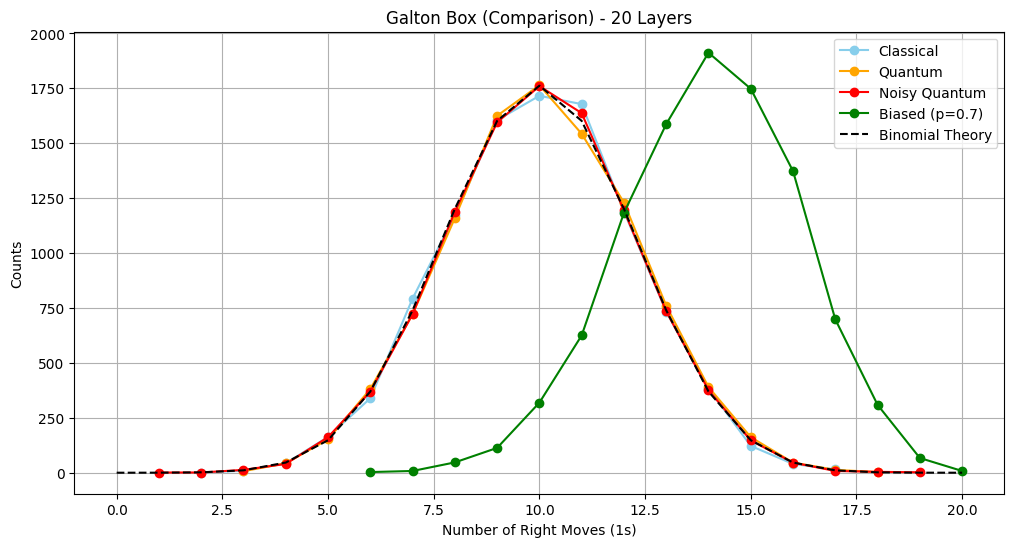

✅ Plot saved at: results/20_layers\galton_box_comparison_20_layers.png

📊 Metrics: Classical vs Quantum
▪️ Total Variation Distance (TVD): 0.0234
▪️ Kullback–Leibler Divergence (KL): 0.0036
▪️ Wasserstein Distance: 0.0510

📊 Metrics: Classical vs Noisy Quantum
▪️ Total Variation Distance (TVD): 0.0140
▪️ Kullback–Leibler Divergence (KL): 0.0019
▪️ Wasserstein Distance: 0.0270

📊 Metrics: Classical vs Biased Classical
▪️ Total Variation Distance (TVD): 0.6409
▪️ Kullback–Leibler Divergence (KL): 2.0112
▪️ Wasserstein Distance: 4.0260


In [4]:
# Comparison of Galton Box Implementations 20_layers.ipynb
# This script compares classical, quantum, noisy quantum, and biased Galton box implementations
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import binom, entropy, wasserstein_distance

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

# --------- Setup ---------
shots = 10000
n_layers = 20
result_dir = "results/20_layers"
os.makedirs(result_dir, exist_ok=True)

# --------- Classical Galton Box ---------
def classical_galton_box(n_layers, shots=10000):
    outcomes = []
    for _ in range(shots):
        steps = [random.choice([0, 1]) for _ in range(n_layers)]
        outcomes.append(sum(steps))
    return Counter(outcomes)

# --------- Quantum Galton Box ---------
def quantum_galton_box(n_layers, shots=10000):
    qc = QuantumCircuit(n_layers, n_layers)
    for i in range(n_layers):
        qc.h(i)
    qc.measure(range(n_layers), range(n_layers))

    sim = AerSimulator()
    tqc = transpile(qc, sim)
    job = sim.run(tqc, shots=shots)
    counts = job.result().get_counts()

    processed = Counter()
    for bitstring, count in counts.items():
        ones = bitstring.count('1')
        processed[ones] += count
    return processed

# --------- Noisy Quantum Galton Box ---------
def noisy_quantum_box(n_layers, shots=10000):
    qc = QuantumCircuit(n_layers, n_layers)
    for i in range(n_layers):
        qc.h(i)
    qc.measure(range(n_layers), range(n_layers))

    noise_model = NoiseModel()
    error = depolarizing_error(0.05, 1)
    noise_model.add_all_qubit_quantum_error(error, ['h'])

    sim = AerSimulator(noise_model=noise_model)
    tqc = transpile(qc, sim)
    job = sim.run(tqc, shots=shots)
    counts = job.result().get_counts()

    processed = Counter()
    for bitstring, count in counts.items():
        ones = bitstring.count('1')
        processed[ones] += count
    return processed

# --------- Biased Galton Box ---------
def biased_galton_box(n_layers, shots=10000, bias=0.7):
    outcomes = []
    for _ in range(shots):
        steps = [1 if random.random() < bias else 0 for _ in range(n_layers)]
        outcomes.append(sum(steps))
    return Counter(outcomes)

# --------- Metric Functions ---------
def normalize_distribution(counter, total, max_key):
    return np.array([counter.get(k, 0) / total for k in range(max_key + 1)])

def calculate_metrics(p_dist, q_dist, label):
    p = np.where(p_dist == 0, 1e-10, p_dist)
    q = np.where(q_dist == 0, 1e-10, q_dist)
    
    tvd = 0.5 * np.sum(np.abs(p - q))
    kl = entropy(p, q)
    wass = wasserstein_distance(range(len(p)), range(len(q)), p, q)

    print(f"\n📊 Metrics: Classical vs {label}")
    print(f"▪️ Total Variation Distance (TVD): {tvd:.4f}")
    print(f"▪️ Kullback–Leibler Divergence (KL): {kl:.4f}")
    print(f"▪️ Wasserstein Distance: {wass:.4f}")

# --------- Run All and Collect ---------
results = {
    "Classical": classical_galton_box(n_layers, shots),
    "Quantum": quantum_galton_box(n_layers, shots),
    "Noisy Quantum": noisy_quantum_box(n_layers, shots),
    "Biased (p=0.7)": biased_galton_box(n_layers, shots, bias=0.7)
}

# --------- Plot ---------
plt.figure(figsize=(12, 6))
colors = ['skyblue', 'orange', 'red', 'green']

for idx, (label, data) in enumerate(results.items()):
    keys = sorted(data.keys())
    values = [data[k] for k in keys]
    plt.plot(keys, values, marker='o', linestyle='-', label=label, color=colors[idx])

x = np.arange(0, n_layers + 1)
theory = binom.pmf(x, n_layers, 0.5) * shots
plt.plot(x, theory, 'k--', label='Binomial Theory')

plt.xlabel('Number of Right Moves (1s)')
plt.ylabel('Counts')
plt.title(f'Galton Box (Comparison) - {n_layers} Layers')
plt.legend()
plt.grid(True)

save_path = os.path.join(result_dir, f'galton_box_comparison_{n_layers}_layers.png')
plt.savefig(save_path)
plt.show()

print(f"✅ Plot saved at: {save_path}")

# --------- Calculate & Print Metrics ---------
max_key = n_layers
classical_norm = normalize_distribution(results["Classical"], shots, max_key)
quantum_norm = normalize_distribution(results["Quantum"], shots, max_key)
noisy_norm = normalize_distribution(results["Noisy Quantum"], shots, max_key)
biased_norm = normalize_distribution(results["Biased (p=0.7)"], shots, max_key)

calculate_metrics(classical_norm, quantum_norm, "Quantum")
calculate_metrics(classical_norm, noisy_norm, "Noisy Quantum")
calculate_metrics(classical_norm, biased_norm, "Biased Classical")

# Save results to files
# End the script
